<a href="https://colab.research.google.com/github/hallpaz/3dsystems23/blob/main/assignments/lab1_fittingfunctions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3D Graphics Systems | AI Graphics - Theory and Practice | IMPA 2023
### Instructor: Luiz Velho
### TA: Hallison Paz
### Course info: https://lvelho.impa.br/i3d23/

# Lab Class #1 - Neural Networks for Function Approximation

Google Colab is an online environment that allows us to write and execute code, and share our solutions with collaborators. We are going to use this environment as our main resource to distribute the assignments of this course as it is particularly useful for experimental and educational code.

The following video (Portuguese only) provides an overview of the Google Colab environment and may help you undestand how to work with many features available in this tool.

In [47]:
from IPython.display import HTML
HTML('''<iframe width="560" height="315" 
        src="https://www.youtube.com/embed/_mIwsA2ddSc" 
        frameborder="0" allow="accelerometer; autoplay; encrypted-media; 
        gyroscope; picture-in-picture" allowfullscreen></iframe>''')

/usr/local/lib/python3.8/dist-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


### 0. Google Colab Setup

First we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

1. Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

2. You can use command line instructions like `ls` and `cd` to find the folder that this notebook is stored. Move to this folder by changing the code below to access your folder:

In [ ]:
%ls "/content/drive/MyDrive/s3d21"

3. If you're using python scripts together with your implementation we recommend using the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) extension. This allows us to edit .py source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [ ]:
%load_ext autoreload
%autoreload 2

# 1. What is an Artificial Neural Network?

## 1.1 Perceptron: the artificial neuron

* Perceptron, [implementação de Thomas Countz](https://www.thomascountz.com/2018/04/05/19-line-line-by-line-python-perceptron)

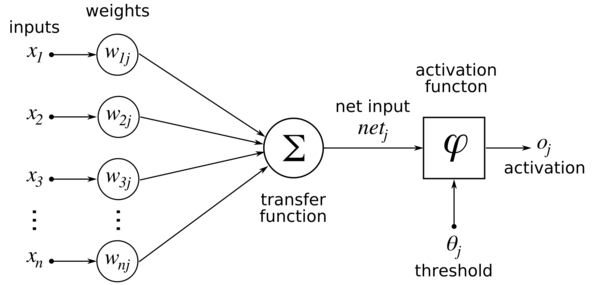

### Warm Up [Optional]

O1. Can you implement a Perceptron without using a deep learning specific framework?

In [ ]:
import numpy as np
# your perceptron implementation here

## 1.2 Multilayer Perceptron

Multilayer Perceptron is a fully connected class of neural networks which presents multiple perceptrons connected in a computational graph that "flows" from inputs to outputs.

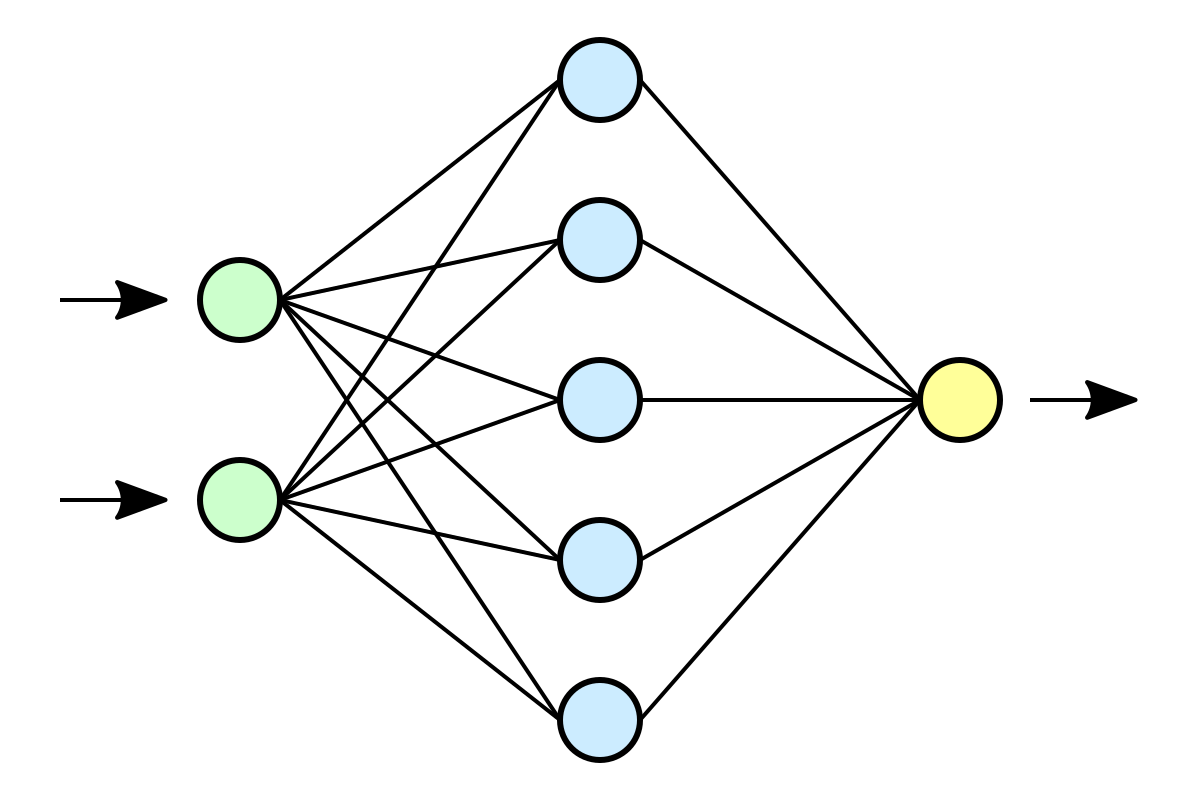

# 2. How can we build a MLP network in PyTorch?

In [ ]:
import torch
import numpy as np
from torch import nn

In [ ]:
class LineNetwork(nn.Module):
  # Initialization
  def __init__(self):
    super().__init__()
    # a single perceptron
    self.layers = nn.Sequential(
        nn.Linear(1, 1)
    )

  # how the network operates
  def forward(self, x):
    return self.layers(x)

# 3. How can we train a neural network?

Let's train our network to regress a simple affine function. A single Perceptron should be able to approximate a line, right?

## 3.1 Preparing the data infrastructure

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch.distributions.uniform as urand

In [ ]:
# This is a Dataset class to work with PyTorch
class AlgebraicDataset(Dataset):
  '''Abstraction for a dataset of a 1D function'''

  def __init__(self, f, interval, nsamples):
    X = urand.Uniform(interval[0], interval[1]).sample([nsamples])
    self.data = [(x, f(x)) for x in X]

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

In [ ]:
# we need a function
line = lambda x: 2*x + 3
# a domain for our function
interval = (-10, 10)
# the number of points we are going to sample for training
train_nsamples = 1000
# the number of points we are going to evaluate our model on
test_nsamples = 100

In [ ]:
train_dataset = AlgebraicDataset(line, interval, train_nsamples)
test_dataset = AlgebraicDataset(line, interval, test_nsamples)

train_dataloader = DataLoader(train_dataset, batch_size=train_nsamples, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=test_nsamples, shuffle=True)

# 3.2 Hyperparameters for Optimization

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"running on {device}")

In [ ]:
model = LineNetwork().to(device)

In [ ]:
# Loss Function: Mean Squared Error
lossfunc = nn.MSELoss()
# SGD = Stochastic Gradient Descent
# lr = learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

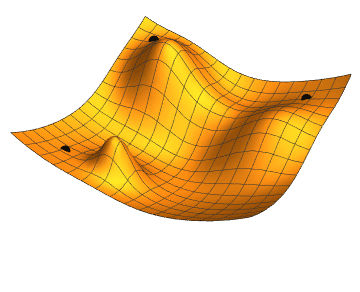

In [ ]:
def train(model, dataloader, lossfunc, optimizer):
  '''A function for training our model'''

  model.train()
  cumloss = 0.0
  for X, y in dataloader:
    X = X.unsqueeze(1).float().to(device)
    y = y.unsqueeze(1).float().to(device)

    pred = model(X)
    loss = lossfunc(pred, y)

    # we need to "clean" the accumulated gradients
    optimizer.zero_grad()
    # computes gradients
    loss.backward()
    # updates parameters going in the direction that decreases the local error
    optimizer.step()

    # loss is a tensor so we use *item* to get the underlying float value
    cumloss += loss.item() 
  
  return cumloss / len(dataloader)


def test(model, dataloader, lossfunc):
  '''A function for evaluating our model on test data'''
  model.eval()
  
  cumloss = 0.0
  with torch.no_grad():
    for X, y in dataloader:
      X = X.unsqueeze(1).float().to(device)
      y = y.unsqueeze(1).float().to(device)

      pred = model(X)
      loss = lossfunc(pred, y)
      cumloss += loss.item() 
  
  return cumloss / len(dataloader)

# 3.3 Training the network



In [ ]:
# for visualization
import imageio
import matplotlib.pyplot as plt
from skimage import img_as_ubyte

In [ ]:
# To visualize results
def plot_comparison(f, model, interval=(-10, 10), nsamples=10, return_array=True):
  fig, ax = plt.subplots(figsize=(10, 10))

  ax.grid(True, which='both')
  ax.spines['left'].set_position('zero')
  ax.spines['right'].set_color('none')
  ax.spines['bottom'].set_position('zero')
  ax.spines['top'].set_color('none')

  samples = np.linspace(interval[0], interval[1], nsamples)
  model.eval()
  with torch.no_grad():
    pred = model(torch.tensor(samples).unsqueeze(1).float().to(device))

  ax.plot(samples, list(map(f, samples)), "o", label="ground truth")
  ax.plot(samples, pred.cpu(), label="model")
  plt.legend()
  plt.show()
  # to return image as numpy array
  if return_array:
    fig.canvas.draw()
    img_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    return img_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))

In [ ]:
epochs = 1001

# Let''s make a Gif of the training
filename_output = "./line_approximation.gif"
writer = imageio.get_writer(filename_output, mode='I', duration=0.3)

for t in range(epochs):
  train_loss = train(model, train_dataloader, lossfunc, optimizer)
  if t % 25 == 0:
    print(f"Epoch: {t}; Train Loss: {train_loss}")
    image = plot_comparison(line, model)
    # appending to gif
    writer.append_data(image)

test_loss = test(model, test_dataloader, lossfunc)
print(f"Test Loss: {test_loss}")
writer.close()

# 4. Now, it's your turn!

You will find below the definition of a new model, a fully connected network with 5 layers and the Rectified Linear Unit function as activation function. You should use the infrastructure defined in the example to train this model to approximate a more sophisticated function (for example, a parabola).

- You are free to experiment with the network architecture: increase or decrease the number of layers; change the number of neurons in specific layers etc.
- You are free to choose the function you'll use to build your dataset. The simplest way to make it work is to build a new instance of AlgebraicDataset passing a new lambda function and a new (or same) domain. However, feel free to experiment more complex ways of defining a function.
- You are free to modify the visualization routine if you want to improve it.
- Experiment different hyperparameters such as number of training epochs, learning rate, or loss function.


In [ ]:
class MultiLayerNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(1, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 8),
        nn.ReLU(),
        nn.Linear(8, 1),
    )

  def forward(self, x):
    return self.layers(x)

In [ ]:
# Write your solution below this cell